In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy as sp
import seaborn as sb
plt = sb.mpl.pyplot

from os.path import join

import glob

from matplotlib.colors import LogNorm
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import cPickle as pickle

In [4]:
from skylab.utils import rotate

In [5]:
def mean_nsig(Phi0, gamma, accept, dec):
    r"""
    Phi0 : float, flux in 1/GeV cm^2 s
    gamma: float, spectral index e.g. -2
    accept: 2D histogram, [x,y,z]
    dec: float, declination position in degree
    """
    return Phi0*acceptance(dec, gamma, accept)


In [6]:
test = False
def get_costta_fromsource(decrad, seed=None):
    r"""
    dec : float, declination
    """
    rs = np.random.RandomState(seed)
    lat_ANT = np.radians(42.798917)
    ct = -1
    it = 0
    while ct<-0.1 and it<1000:
        HA = rs.uniform(0.,2*np.pi)
        ct = -np.sin(lat_ANT)*np.sin(decrad) + np.cos(lat_ANT)*np.cos(decrad)*np.cos(HA)
        it += 1
    if ct<-0.1: ct = -0.1
    return ct

if test:
    num = 1000
    dec = np.arcsin(np.linspace(-1.,0.8, num=num))
    ct = np.zeros((num,))
    for i,dd in enumerate(dec):
        ct[i] += get_costta_fromsource(dd)

    mask = ct<=-0.1
    mask1 = np.logical_and(ct>-0.1, ct<0.2)
    mask2 = np.logical_and(ct>=0.2, ct<0.6)
    mask3 = ct>0.6
    sb.distplot(ct[~mask])
    plt.figure()
    plt.scatter(np.sin(dec[mask1]),ct[mask1])
    plt.scatter(np.sin(dec[mask2]),ct[mask2])
    plt.scatter(np.sin(dec[mask3]),ct[mask3])
    plt.scatter(np.sin(dec[mask]),ct[mask])



    print np.count_nonzero(mask)

## draw events

In [7]:
def draw_from_inv_function(f_int_inv, n, rs=np.random.RandomState()):
    n = int(n)    
    rn = rs.uniform(0,1,size=n)
    return f_int_inv(rn)

In [32]:
def generate_inv_function(x, vals):
    norm = np.sum(vals)
    f_int = np.cumsum(vals)*1./norm
    assert(abs(f_int[-1]-1.)<1e-5)
    return InterpolatedUnivariateSpline(f_int, x, k=1)

In [8]:
def draw_bg(data_1d_x_dict, data_1d_y_dict, 
            n=1, rs=np.random.RandomState(),
            debug=False
           ):
    n = int(n)
    names = ["ra", "sinDec", "logE", "beta"]
    # beta is meant to be a reco uncertainty estimated from PSF
    
    events = np.zeros((n,), dtype=[(nm,np.float) for nm in names])
    
    events["sinDec"] = draw_from_inv_function(data_1d_x_dict["inv_spline_0"], n, rs)
    events["beta"] = draw_from_inv_function()
    x = data_1d_x_dict["raw_0"][0]
    dx = x[1]-x[0]
    x = np.concatenate([[x[0]-0.5*dx], x+0.5*dx])
    x[0] = min(events["sinDec"])-dx
    x[-1] = max(events["sinDec"])+dx
    selected_bins = np.digitize(events["sinDec"], x)
    if debug:         
        print np.unique(selected_bins)
        print min(selected_bins), max(selected_bins)
    for i,sc in enumerate(selected_bins):
        events["logE"][i] = draw_from_inv_function(data_1d_y_dict["inv_spline_{}".format(sc-1)], 1, rs)
        
    events["ra"] = rs.uniform(0., np.pi*2., size=n)
    return events


In [8]:
def linear_interpolate_splines(spline1, spline2, x1, x2, xtarget):
    r"""
    Interpolate between spline1 and spline2, characterized by x1 and x2
    Target is a third spline characterized by xtarget
    
    Return interpolated spline
    """
    pass

def draw_source(data_1d_x_dict, data_1d_y_dict, 
                src_ra, src_dec,
                n=1, rs=np.random.RandomState(),
                debug=False
               ):
    n = int(n)
    names = ["ra", "sinDec", "logE", "beta"]
    # beta is meant to be a reco uncertainty estimated from PSF
    events = np.zeros((n,), dtype=[(nm,np.float) for nm in names])
    
    events["sinDec"] = draw_from_inv_function(data_1d_x_dict["inv_spline_0"], n, rs)
    x = data_1d_x_dict["raw_0"][0]
    dx = x[1]-x[0]
    x = np.concatenate([[x[0]-0.5*dx], x+0.5*dx])
    x[0] = min(events["sinDec"])-dx
    x[-1] = max(events["sinDec"])+dx
    selected_bins = np.digitize(events["sinDec"], x)
    if debug:         
        print np.unique(selected_bins)
        print min(selected_bins), max(selected_bins)
    for i,sc in enumerate(selected_bins):
        events["logE"][i] = draw_from_inv_function(data_1d_y_dict["inv_spline_{}".format(sc-1)], 1, rs)
        
    events["ra"] = rs.uniform(0., np.pi*2., size=n)
    return events


1.2779694560962305


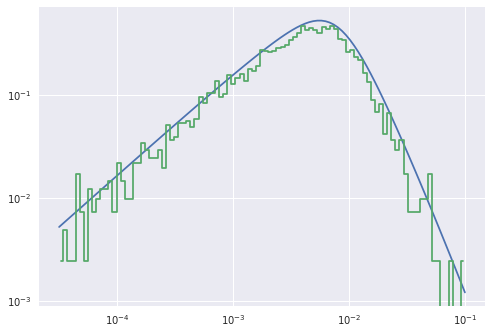

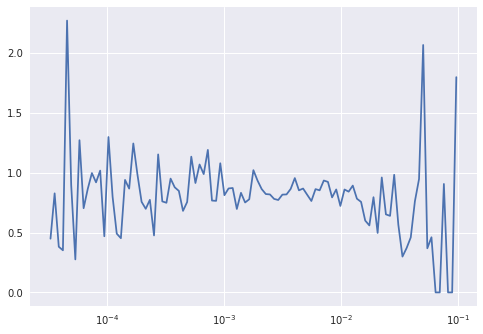

In [78]:
test=True
def psf2D_gamma(ra, dec, ra_0, dec_0, gamma):
    r"""
    Well defined on np.power(10, [-4.5, 0])
    ra, dec: float, position in radian
    ra_0, dec_0: float, source position in radian
    gamma : float, source spectral index
    """
    # shape 5 x 4
    b = [[6.807,6.149,3.888,0.865],
         [115.115,182.058,96.405,16.482],
         [-465.904,-789.718,-428.301,-74.354],
         [697.181,1217.255,706.056,129.503],
         [-257.106, -710.004, -432.294, -76.251]]

    # double a[5];
    a = np.array([np.sum(np.poly1d(np.flip(bj, axis=0))(gamma)) for bj in b])
    

    sindec = np.sin(dec)
    cosdec = np.sqrt(1.- sindec**2)
    cosa = np.cos(dec_0)*cosdec*np.cos(ra-ra_0) + np.sin(dec_0)*sindec
    sina = np.sqrt(1.-cosa**2)
    ang = np.degrees(np.arccos(cosa))

    if np.abs(ang<0.001): return a[0]

    num = a[0]*ang
    denom = 1. + np.sum(np.poly1d(np.flip(a, axis=0))(ang))
    return num/(sina*denom)

if test:
    ra_0 = 0.
    dec_0 = 0.
    num = 100
    ra = np.zeros((num,))
    dec = np.logspace(-4.5, -1, num=num)
    gamma = -2
    plt.figure()
    res = np.empty((num,))
    for i,(rr,dd) in enumerate(zip(ra,dec)):
        res[i] = psf2D_gamma(rr,dd,ra_0,dec_0,gamma)
    print np.sum(np.sin(dec))
    norm = np.sum(res*np.sin(dec))
    inv_PSF = generate_inv_function(dec, res*np.sin(dec))
    r_vals = draw_from_inv_function(inv_PSF, num*50)
    h,ed = np.histogram(r_vals, density=True, bins=dec)
    mid = 0.5*(ed[1:]+ed[:-1])
    plt.plot(dec, res*np.sin(dec)*norm)
    
    plt.step(mid, h*np.sin(mid), where="mid")
    
    plt.loglog()
    
    plt.figure()
    original_spline = InterpolatedUnivariateSpline(dec, res*np.sin(dec)*norm)
    plt.plot(mid, (h*np.sin(mid))/original_spline(mid))
    plt.semilogx()
 

In [ ]:
ra_0 = 0.
dec_0 = 0.
num = 100
ra = np.zeros((num,))
dec = np.logspace(-4.5, -1, num=num)
gamma = -2
plt.figure()
res = np.empty((num,))
for i,(rr,dd) in enumerate(zip(ra,dec)):
    res[i] = psf2D_gamma(rr,dd,ra_0,dec_0,gamma)
print np.sum(np.sin(dec))
inv_PSF = generate_inv_function(dec, res*np.sin(dec))
r_vals = draw_from_inv_function(inv_PSF, num*50)
h,ed = np.histogram(r_vals, density=True, bins=dec)
mid = 0.5*(ed[1:]+ed[:-1])
plt.plot(dec, res*np.sin(dec))

plt.step(mid, h*np.sin(mid), where="mid")

plt.loglog()

plt.figure()
original_spline = InterpolatedUnivariateSpline(dec, res*np.sin(dec))
plt.plot(mid, original_spline(mid)/(h*np.sin(mid)))
plt.semilogx()


In [ ]:
def set_injection_position(dec, ra, func=None, rs=np.random.RandomState(), **kwargs):
    """
    Meant to be used for signal injection
    
    dec, ra: true source position
    sigma: estimated 1D uncertainty
    
    returns:
    deviated event position and angular distance
    dec_rot, ra_rot: array, len(dec/ra)
    dist: array of angular distances from dec/ra_rot to dec/ra, len(dec)
    """
    ra3 = rs.uniform(0, np.pi*2., size=len(dec))
    if func==None:
        sigma = kwargs.pop("sigma")
        dec3 = rayleigh.rvs(scale=sigma, size=len(dec)) - np.pi/2.
    ra_rot, dec_rot = rotate(0., -1.*np.pi/2.,
                             ra, dec, 
                             ra3, dec3)
    dist = np.arccos(np.sin(dec)*np.sin(dec_rot)+np.cos(dec)*np.cos(dec_rot)*np.cos(ra-ra_rot))
    return dec_rot, ra_rot, dist

Bkg_PDF
Sig_PDF_Gam18
Sig_PDF_Gam19
Sig_PDF_Gam20
Sig_PDF_Gam21
Sig_PDF_Gam22
Sig_PDF_Gam23
Sig_PDF_Gam24
Sig_PDF_Gam25
Sig_PDF_Gam26
Sig_PDF_Gam27


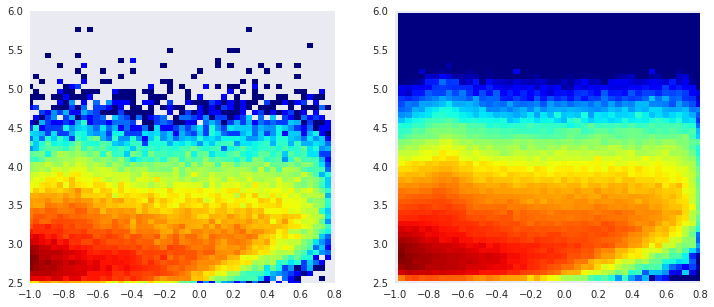

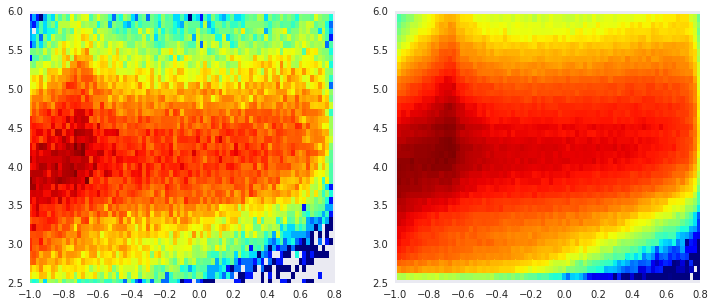

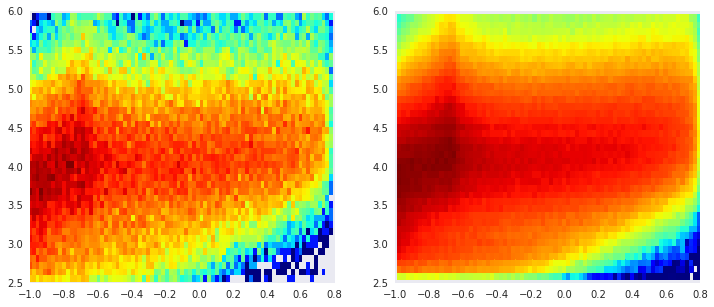

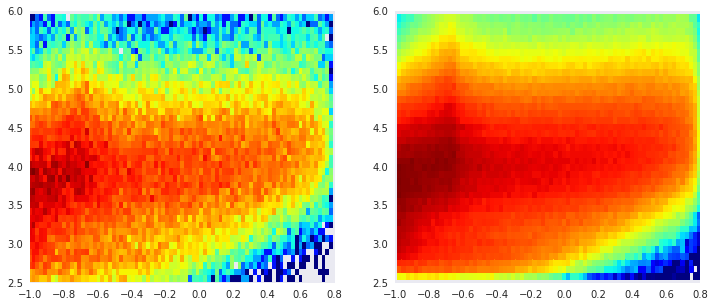

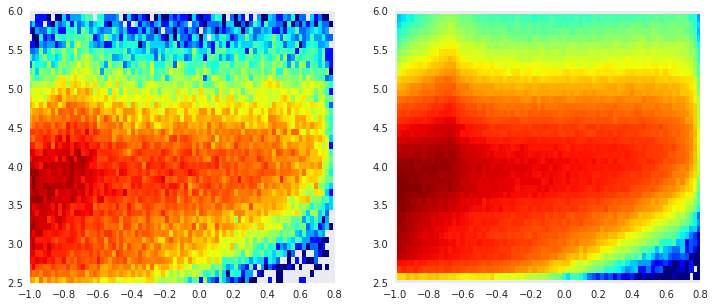

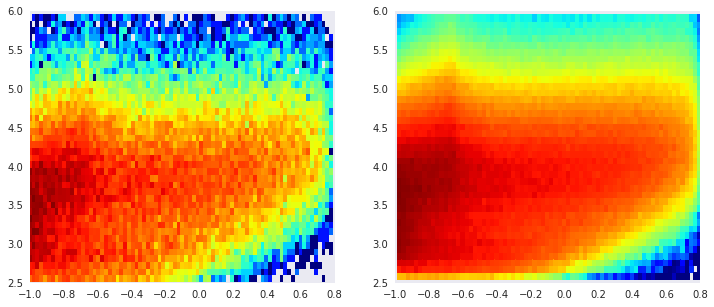

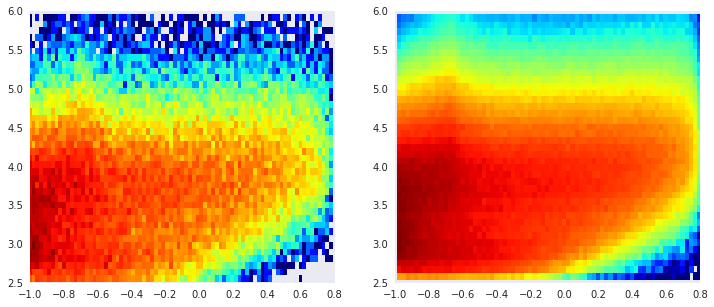

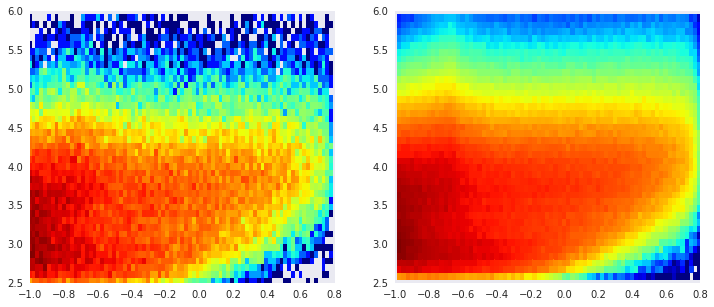

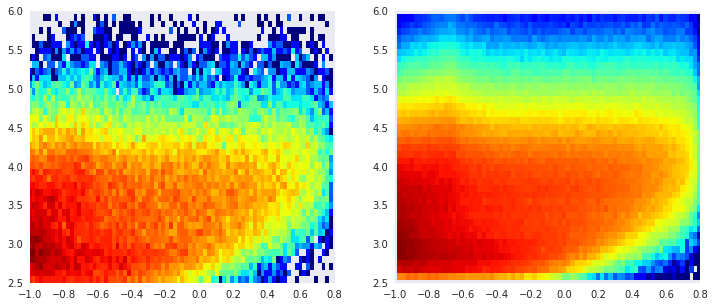

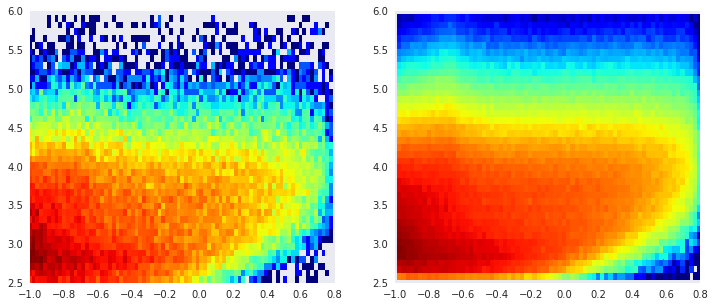

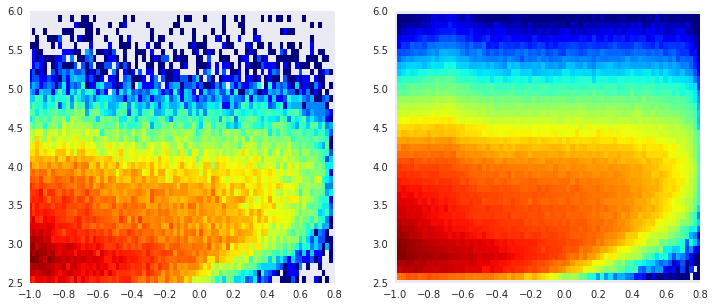

In [128]:
ant_path = "/home/lschumacher/antares/LL_ingredients/"
logE_range = (2.5,6)
sindec_range = (-1, 0.8)
files = sorted(glob.glob(join(ant_path, "*")))

for f in files:
    
    data = np.genfromtxt(f)
    identifier = f.split("/")[-1].split(".")[0]
    print identifier
    with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_x.pkl".format(identifier), "rb") as f:
        data_1d_x_dict = pickle.load(f)

    with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_y.pkl".format(identifier), "rb") as f:
        data_1d_y_dict = pickle.load(f)
    events = draw_bg(data_1d_x_dict, 
                         data_1d_y_dict, n=1e5, 
                         #debug=True
                        )
    rn_x = events["sinDec"]
    rn_y = events["logE"]
    #print rn_y[rn_y==np.nan]
    mask = np.logical_and(rn_y>=2.45, rn_y<=6.05)
    if np.count_nonzero(~mask) >0:
        print np.count_nonzero(~mask)
        print rn_y[~mask]
        print min(rn_x), max(rn_x)
        print min(rn_y), max(rn_y)
        
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
    if "Bkg" in identifier: bins=[50,50]
    else: bins=[80, 40]
    h, xedges, yedges, im = ax1.hist2d(rn_x[mask], rn_y[mask], normed=True, norm=LogNorm(), 
                                       cmap=plt.cm.jet, 
                                       bins=bins
                                      )
    ax1.grid(False)
    ax1.set_xlim(sindec_range)
    ax1.set_ylim(logE_range)


    logE_sindec_pdf_dict = dict()
    s_mask = np.logical_and(data[:,0]>=sindec_range[0], data[:,0]<=sindec_range[1])
    e_mask = np.logical_and(data[:,1]>=logE_range[0], data[:,1]<=logE_range[1])
    mask = np.ones_like(data[:,0], dtype=bool) #np.logical_and(s_mask, e_mask)
    logE_sindec_pdf_dict["sinDec"] = data[:,0][mask]
    logE_sindec_pdf_dict["logE"] = data[:,1][mask]
    logE_sindec_pdf_dict["value"] = data[:,2][mask]
    logE_sindec_pdf_dict["value"][logE_sindec_pdf_dict["value"]<=0] = min(logE_sindec_pdf_dict["value"])
    vmax = 1
    vmin = 1e-3
    xbins = len(np.unique(logE_sindec_pdf_dict["sinDec"]))
    ybins = len(np.unique(logE_sindec_pdf_dict["logE"]))


    ax2.pcolor(logE_sindec_pdf_dict["sinDec"].reshape(xbins, ybins), 
                    logE_sindec_pdf_dict["logE"].reshape(xbins, ybins), 
                    logE_sindec_pdf_dict["value"].reshape(xbins, ybins),
                    vmin=vmin,
                    #vmax=vmax,
                    norm=LogNorm(),
                    cmap=plt.cm.jet)
    ax2.set_xlim(sindec_range)
    ax2.set_ylim(logE_range)
    #break
    

In [203]:
def acceptance(dec, gamma, accept_hist):
    r"""
    dec : float, degree
    gamma : float, negative
    Accept : 2D histogram, i.e. [x,y,z]
    """
    x = np.sin(np.radians(dec))
    accept_spline = RectBivariateSpline(accept_hist[0], accept_hist[1], accept_hist[2])
    return accept_spline(x, gamma)
    